# Implementación de un modelo de deep learning. (Portafolio Implementación) | Mejora del modelo

### Angel Mauricio Ramírez Herrera A01710158

---

# Importar Glove

GloVe (Global Vectors for Word Representation) es un algoritmo no supervisado que genera representaciones vectoriales de palabras a partir de grandes corpus de texto. Estas representaciones capturan las relaciones semánticas y sintácticas entre las palabras, revelando estructuras lineales dentro del espacio vectorial (por ejemplo, relaciones como rey - hombre + mujer ≈ reina).

In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip


--2025-11-12 15:13:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-11-12 15:13:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-11-12 15:13:50--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

# Resumen Breve

Este proyecto tiene como objetivo clasificar letras de canciones en su género musical correspondiente mediante NLP. Para ello, se realiza un análisis exploratorio y preprocesamiento de los datos que garantice un entrenamiento efectivo del modelo.

El dataset original contiene aproximadamente 5 millones de registros. Debido a las limitaciones computacionales del entorno gratuito de Google Colab, se decidió cambiar el entorno de ejecución a Kaggle, el entrenamiento se realizará con un subconjunto de menos de 2,200,000 registros para obtener una mejor generalización.

El modelo combina una CNN con una GRU bidireccional para la clasificación de letras de canciones. Utiliza vectores preentrenados Glove como embeddings iniciales, lo que permite que el modelo aprenda más rápido el significado y contexto semántico de las palabras.

El preprocesamiento incluye las letras de las canciones limpias con regex, tokenización de 20,000 palabras, conversión a secuencias numéricas y padding para que las letras no excedan 300 tokens.

La capa convolucional extrae los patrones locales y combinaciones de palabras relevantes, mientras que la GRU bidireccional captura las dependencias contextuales en ambas direcciones de la secuencia. Finalmente se tienen capas densas con dropout para evitar el overfiting y generalizar.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional, BatchNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from google.colab import drive
from tensorflow import keras
import os

In [10]:
def get_dir_size(path):
    total = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total += os.path.getsize(fp)
    return total

def count_empty(df):
    return df.select([
        sum(when(trim(col(c)) == "", 1).otherwise(0)).alias(c)
        for c in df.columns if dict(df.dtypes)[c] == 'string'
    ])

# Extraer los datos crudos

---

El dataset utilizado contiene información recopilada durante 2022 desde la plataforma Genius, un sitio colaborativo donde los usuarios pueden subir y transcribir letras de canciones, poemas e incluso fragmentos de libros aunque su uso principal está enfocado en la música.

Este conjunto de datos incluye aproximadamente 5 millones de canciones, junto con sus respectivas letras.
Las letras provienen directamente del formato nativo de Genius, el cual requiere un preprocesamiento cuidadoso antes de ser analizado o utilizado para entrenar modelos de Deep Learning.

En particular:

- Las letras suelen incluir metadatos entre corchetes, como [Verse 1], [Chorus] o [Produced by ...], que no forman parte del contenido lírico y deben eliminarse o tratarse.

- La estructura original del texto mantiene los saltos de línea y secciones tal como aparecen en la transcripción, lo cual puede generar dificultades al leer los datos o al pasarlos a modelos que esperan texto plano.

- Además, otras columnas del dataset (como los campos de features o descripciones adicionales) también requieren limpieza y normalización antes de ser utilizadas en el pipeline de procesamiento.

In [11]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("carlosgdcj/genius-song-lyrics-with-language-information")

print("Path to dataset files:", path)

size_bytes = get_dir_size(path)
size_mb = size_bytes / (1024 * 1024)

print(f"Tamaño total de los archivos: {size_mb:.2f} MB")

Path to dataset files: /kaggle/input/genius-song-lyrics-with-language-information
Tamaño total de los archivos: 8650.20 MB


## Tamaño del Dataset

El dataset descargado ocupa 8650.20 MB (aproximadamente 8.44 GB) en disco. Aunque en Kaggle se reporta un tamaño de 9.07 GB, esta diferencia puede deberse a la compresión de archivos o a variaciones en cómo se calcula el tamaño. Con este volumen de datos, se cuenta con información suficiente para entrenar un modelo de deep learning. En este proyecto, se implementará una red neuronal recurrente basada en GRU (Gated Recurrent Unit) para realizar clasificación de textos.

In [13]:
files = os.listdir(path)
csv_file = [f for f in files if f.endswith('.csv')][0]
csv_path = os.path.join(path, csv_file)

Para limitar el tamaño de los datos y optimizar el uso de recursos computacionales durante el entrenamiento y la limpieza del dataset, se seleccionaron únicamente 2,200,000 filas mediante el parámetro nrows=2200000.

Esta reducción permite:

- Acelerar el proceso de carga, preprocesamiento y entrenamiento.
- Disminuir el uso de memoria RAM de la GPU y tiempo de cómputo.
- Hacer viable el entrenamiento en Kaggle en un tiempo considerable.

Sin embargo, esta decisión implica una disminución potencial en el rendimiento del modelo, ya que al disponer de menos ejemplos:

- Se reduce la diversidad y representatividad de los datos.
- El modelo puede aprender menos patrones o generalizar peor frente a datos nuevos.

In [14]:
import pandas as pd

df = pd.read_csv(
    csv_path,
    nrows=2200000,
    on_bad_lines='skip',
    low_memory=False
)

## Selección de features

El dataset original contiene diversas columnas con información sobre las canciones, entre ellas:

`title, tag, artist, year, views, features, lyrics, id, language_cld3, language_ft y language.`

Se determinó que para los fines del proyecto (entrenar un modelo que clasifique las letras según su género musical) no todas las variables son necesarias.

In [15]:
df.head(10)

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1,en,en,en
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3,en,en,en
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4,en,en,en
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5,en,en,en
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6,en,en,en
5,Lollipop Remix,rap,Lil Wayne,2008,580832,"{""Kanye West"",""Static Major""}",[Intro: Lil Wayne]\nHaha\nUh-huh\nNo homo (You...,7,en,en,en
6,Im Not You,rap,Clipse,2002,28645,"{Jadakiss,""Styles P"",""Roscoe P. Coldchain""}","[Intro: Pusha T]\nNo, no, no!\nI told you, I l...",8,en,en,en
7,Family Ties,rap,Cam'ron,2004,41960,"{""Cam\\'ron"",""Lady Wray""}","[Verse 1: Cam'ron]\nKilla, Dipset\nMan I spit ...",9,en,en,en
8,Rockin and Rollin,rap,Cam'ron,1998,6399,"{""Cam\\'ron""}",[Verse 1]\nAy yo you wonder who I are\nI guzzl...,10,en,en,en
9,Lord You Know,rap,Cam'ron,2004,11882,"{""Cam\\'ron"",""Juelz Santana"",Jaheim}","[Chorus: Jaheim]\nNow Lord you know, just how ...",11,en,en,en


Observamos que existen un porcentaje bajo de valores nulos dentro de las 2,200,000 filas que seleccionamos.

In [16]:
(df.isnull().sum() / len(df) * 100).round(2).sort_values(ascending=False)

language         3.08
language_ft      1.83
language_cld3    1.20
artist           0.00
tag              0.00
title            0.00
year             0.00
lyrics           0.00
features         0.00
views            0.00
id               0.00
dtype: float64

El análisis de frecuencia de géneros muestra que rap es el género predominante en el dataset, seguido por misc, rock, pop, country y finalmente R&B, que presenta la menor representación.

In [17]:
df['tag'].value_counts(dropna=False)

tag
pop        1163647
rap         525976
rock        287507
misc        134140
rb           48037
country      40693
Name: count, dtype: int64

La mayoría de las canciones disponibles en el dataset están en inglés, con un total de 1,590,723 registros en este idioma.

In [18]:
df['language'].value_counts(dropna=False)

language
en    1590723
es     114592
fr      87054
de      78423
pt      67823
       ...   
kn          2
ml          2
mt          1
bs          1
te          1
Name: count, Length: 77, dtype: int64

# Transformación de datos
---

## Filtrado por idioma

Se seleccionan únicamente las canciones cuyo idioma es inglés (language == 'en'), con el propósito de entrenar el modelo con un conjunto de datos lingüísticamente homogéneo y evitar sesgos debidos a diferencias idiomáticas.

In [19]:
filtered_df = df[df['language'] == 'en']

In [20]:
(filtered_df.isnull().sum() / len(df) * 100).round(2).sort_values(ascending=False)

title            0.0
tag              0.0
artist           0.0
year             0.0
views            0.0
features         0.0
lyrics           0.0
id               0.0
language_cld3    0.0
language_ft      0.0
language         0.0
dtype: float64

El ranking de los géneros más populares en las canciones se mantiene igual al filtrar el lenguaje.

In [21]:
filtered_df['tag'].value_counts(dropna=False)

tag
pop        818140
rap        329825
rock       250069
misc       110956
rb          42846
country     38887
Name: count, dtype: int64

## Normalizar el tamaño de los datos

Con el fin de evitar el sobreajuste (overfitting) observado en el modelo anterior, se identificará el género musical con menor cantidad de datos y se usará como referencia para balancear el tamaño de las demás clases. De esta manera, se entrena el modelo con un conjunto equilibrado, reduciendo el sesgo hacia géneros con más muestras y mejorando su capacidad de generalización.

In [22]:
import pandas as pd

min_count = df['tag'].value_counts().min()

df_trimmed = (
    df.groupby('tag', group_keys=False)
      .apply(lambda x: x.sample(min_count, random_state=42))
      .reset_index(drop=True)
)

df_trimmed = df_trimmed.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_trimmed['tag'].value_counts().sort_index())

/tmp/ipykernel_48/2090164797.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_count, random_state=42))


tag
country    40693
misc       40693
pop        40693
rap        40693
rb         40693
rock       40693
Name: count, dtype: int64


## Selección de columnas relevantes

Dado que el obetivo es clasificar las letras (lyrics) según su género musical (tag), se conservan únicamente estas dos columnas en el dataset limpio:
- tag: género musical (etiqueta objetivo).
- lyrics: texto de la canción (característica principal para el modelo).

In [23]:
df_trimmed.drop(columns=['title', 'artist', 'year', 'views', 'features', 'id', 'language_cld3', 'language_ft', 'language'], inplace=True)

In [24]:
df_trimmed.head(10)

,tag,lyrics
0,pop,I heard her footsteps down the hallway\nI hear...
1,pop,I'm lost without you\nCan't help myself\nHow d...
2,misc,In my tortured ears there sounds unceasingly a...
3,misc,"Aue, aue\nUm rumo pra seguir\nE tantas ilhas p..."
4,pop,Here we are with good-bye in our eyes\nRunning...
5,rap,"(Chorus)\nI need, a lover.. who can..\nTake it..."
6,rap,[Intro: Young Buck & 50 Cent]\nK'Yeah!! (Man I...
7,pop,Do you know who I am?\nDo you know who I am?\n...
8,pop,Se que he perdido el corazón suspirando por tu...
9,country,Sometimes it's hard to be a woman\nGiving all ...


## Limpieza de las letras

Ahora, se limpian las letras de las canciones aplicando regex para su transformación, esto nos ayuda ya que los modelos NLP funcionan mejor con texto limpio y normalizado, lo que reduce el ruido y el tamaño del vocabulario:

1. Elimina texto que se encuentra entre corchetes como [Chorus], [Verse 1]... que son metadatos dentro de la letra.
```
r'\[.*?\]'
```
2. Remplaza los saltos de linea por un espacio simple para convertir todo a una sola línea.
```
r'\n+'
```
3. Elimina todos los carácteres, excepto letras (a-z, A-Z) y espacios. Esto ayuda a remover números, signos de puntuación y carácteres especiales.
```
r'[^a-zA-Z\s]'
```
4. Compacta los espacios consecutivos en uno solo.
```
r'\s+'
```
5. Elimina los espacos en blanco al inicio y al final de cada letra.
```
.strip()
```
6. Convierte todo a minúsculas para la normalización de las palabras y tratar a todas las palabras por igual.
```
.lower()
```

In [25]:
df_trimmed['lyrics_clean'] = (
    df_trimmed['lyrics']
    .str.replace(r'\[.*?\]', '', regex=True)
    .str.replace(r'\n+', ' ', regex=True)
    .str.replace(r'[^a-zA-Z\s]', ' ', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
    .str.lower()
)

In [26]:
df_trimmed.head(10)

,tag,lyrics,lyrics_clean
0,pop,I heard her footsteps down the hallway\nI hear...,i heard her footsteps down the hallway i heard...
1,pop,I'm lost without you\nCan't help myself\nHow d...,i m lost without you can t help myself how doe...
2,misc,In my tortured ears there sounds unceasingly a...,in my tortured ears there sounds unceasingly a...
3,misc,"Aue, aue\nUm rumo pra seguir\nE tantas ilhas p...",aue aue um rumo pra seguir e tantas ilhas para...
4,pop,Here we are with good-bye in our eyes\nRunning...,here we are with good bye in our eyes running ...
5,rap,"(Chorus)\nI need, a lover.. who can..\nTake it...",chorus i need a lover who can take it easy i w...
6,rap,[Intro: Young Buck & 50 Cent]\nK'Yeah!! (Man I...,k yeah man i been tellin niggas ova and ova ma...
7,pop,Do you know who I am?\nDo you know who I am?\n...,do you know who i am do you know who i am do y...
8,pop,Se que he perdido el corazón suspirando por tu...,se que he perdido el coraz n suspirando por tu...
9,country,Sometimes it's hard to be a woman\nGiving all ...,sometimes it s hard to be a woman giving all y...


## Preparar datos para el modelo

1. Variable texts: Convierte la columna de 'lyrics_clean' a una lista de strings. Cada elemento es la letra completa de la canción.
2. Variable labels: Extrae los géneros musicales (ej: "rap", "pop", "rock") como lista.
3. Función LabelEncoder(): Convierte las etiquetas de texto a números, esto es importante porque las redes neuronales solo procesan números.

In [35]:
texts = df_trimmed['lyrics_clean'].astype(str).tolist()
labels = df_trimmed['tag'].astype(str).tolist()

In [36]:
le = LabelEncoder()
y = le.fit_transform(labels)

# Modelado

---

## Hiperparámetros

**MAX_WORDS** = 20,000: El vocabulario se limitará a 20,000 más frecuentes de las letras y las palabras menos comunes se van a marcar como desconocidas

¿Por qué se eligieron solo 20,000 palabras? Para obtener un balance entre un vocabulario amplio.

**MAX_LEN** = 350: Cada letra solo va a contener 350 palabras, si la letra tiene menos de 350 palabras, entonces se rellena con ceros hasta 350.

**EMBED_DIM** = 200: Es la dimensión del embedding que empata con la versión que se va a utilizar de Glove, significa que cada palabra se convierte en un vector de 200 valores reales [0.12, -0.45, 0.98, ...] con 200 posiciones.

## Tokenización

1. Función Tokenizer(): Crea un objeto que va a convertir el texto a secuencias numéricas para que el modelo pueda entender el lenguaje humano.
2. Parámetro oov_token = "OOV" (Out Of Vocabulary): Cualquier palabra no reconocida se replaza con ese token.
3. Función .fit_on_texts(texts): Cuenta cuántas veces aparece cada palabra y asigna un número único a cada una empezando por las más frecuentes.

## Conversión a secuencias y padding

Después de definir la conversión del lenguaje humano a números que el modelo puede procesar.

1. **Función texts_to_sequences(texts)**: Convierte cada letra de canción a una secuencia de números utlizando el vocabulario aprendido.
- **Entrada**: "que bonitos ojos tienes quiero"
- **Salida**: [1, 32, 180, 45, 3]
2. pad_sequences(): Estandariza todas las secuencias a solo los 300 elementos.
- **maxlen = 300**: Longitud máxima
- **padding = 'post'**: Rellena con ceros al final si es que la secuencia es muy corta.
- **truncating = 'post'**: Corta desde el final si la secuencia es muy larga y lo deja en el maxlen.

In [32]:
MAX_WORDS = 20000
MAX_LEN = 350
EMBED_DIM = 200

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

X = tokenizer.texts_to_sequences(texts)
X = pad_sequences(X, maxlen=MAX_LEN, padding='post', truncating='post')

## Cargar glove embeddings

Esta función convierte los vectores preentrenados de GloVe en una matriz de embeddings que el modelo puede usar como pesos iniciales en la capa embedding.
Así, cada palabra del vocabulario se asocia con un vector semántico aprendido previamente (en lugar de entrenarlo desde cero).

1. Carga los vectores de Glove, abre el archivo .txt que se va a utilizar. Cada línea del .txt contiene una palabra seguida de sus valores vectoriales.
2. Se guarda en un diccionario 'embedding_index' la palabra y los pesos asociados.
3. Se inicializa una matriz vacía(inicialmente llena de ceros) de embeddings con el tamaño del vocabulario 'num_words' por la dimensión de los embeddings.
4. Recorre todas las palabras del vocabulario que usó el tokenizer y si la palabra se encuentra en Glove, copia su vector en la posición correspondiente de la embedding_matrix.
5. Si no existen palabras similares en Glove, se deja el vector en ceros.
6. Finalmente se devuelve la matriz 'embedding_matrix'

In [30]:
def load_glove_embeddings(glove_file, word_index, embedding_dim):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    num_words = min(MAX_WORDS, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, embedding_dim))

    for word, i in word_index.items():
        if i >= MAX_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [37]:
embedding_matrix = load_glove_embeddings(
    'glove.6B.200d.txt',
    tokenizer.word_index,
    EMBED_DIM
)

## Guardar tokenizers

Se guardan los tokenizers para poder usarlos después, por ejemplo al evaluar el modelo o hacer predicciones nuevas.

In [38]:
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)


## Dividir datos
Para evaluar de forma justa el rendimiento del modelo, el conjunto de datos se divide en tres subconjuntos:

- **Entrenamiento** (70%): usado para ajustar los parámetros del modelo.
- **Validación** (15%): permite ajustar hiperparámetros y prevenir sobreajuste durante el entrenamiento.
- **Prueba** (15%): se reserva completamente para evaluar el desempeño final en datos nunca vistos.

In [39]:
from sklearn.model_selection import train_test_split

# Primer split: separar test (15% del total)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Segundo split: separar train y validation del restante 85%
# validation será ~17.6% del 85% = 15% del total
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Val:   {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

Train: 171008 samples (70.0%)
Val:   36526 samples (15.0%)
Test:  36624 samples (15.0%)


## Arquitectura por capa

#### Embedding(...): Capa de entrada con vectores GloVe

Traduce los índices de palabras a representaciones semánticas ricas, aprovechando el conocimiento previo de GloVe sobre relaciones entre palabras.

- Entrada: Secuencias de números enteros (índices de palabras).
- Salida: Vectores densos de EMBED_DIM dimensiones para cada palabra.
Parámetros clave:
- input_dim=MAX_WORDS: tamaño del vocabulario (15,000 palabras).
- weights=[embedding_matrix]: inicializa la capa con embeddings preentrenados GloVe.
- trainable=True: permite ajustar ligeramente los vectores durante el entrenamiento.
- input_length=MAX_LEN: longitud fija de cada secuencia (300 tokens).

#### Conv1D(64, 5, activation='relu'): Capa convolucional 1D

Extrae características locales y estructuras comunes, como frases o expresiones típicas de un género musical.

- 64 filtros: detectan patrones locales de palabras (n-gramas) dentro de las secuencias.
- Kernel size = 5: ventana deslizante que capta combinaciones de hasta 5 palabras consecutivas.
- ReLU: activa solo valores positivos, aportando no linealidad.

#### MaxPooling1D(pool_size=2): Capa de reducción

- Reduce la dimensionalidad al conservar solo las características más relevantes de cada filtro.
- Hace que la red sea más eficiente y resistente al ruido en el texto.


#### Dropout(0.3): Regularización

- 30 % de neuronas desconectadas aleatoriamente.
- Evita overfitting, ayudando a que el modelo generalice mejor.


#### Bidirectional(GRU(64, dropout=0.3, recurrent_dropout=0.3)): Capa recurrente bidireccional

Captura el contexto global de la letra, entendiendo cómo una palabra depende de las anteriores y posteriores.

- 64 unidades GRU: cada una procesa dependencias a largo plazo en la secuencia.
- Bidireccional: lee el texto tanto de izquierda a derecha como de derecha a izquierda.
- Dropout y recurrent_dropout = 0.3: previenen sobreajuste tanto en conexiones estándar como recurrentes.

#### Dense(32, activation='relu'): Capa totalmente conectada

Aprende combinaciones de características de alto nivel que representan el estilo o tema de la letra.

- 32 neuronas: condensan la información aprendida por la GRU.
- ReLU: mantiene la no linealidad.

#### Dropout(0.4): Regularización adicional

- 40 % de neuronas desconectadas.
- Refuerza la capacidad de generalización del modelo antes de la clasificación final.

#### Dense(num_classes, activation='softmax'): Capa de salida

- Realiza la clasificación final según la probabilidad de pertenencia a cada género.
- Neuronas: una por cada clase (género musical).
- Softmax: transforma los valores en probabilidades que suman 1.

#### Ejemplo de salida

[0.05, 0.70, 0.10, 0.05, 0.10] → 70 % de probabilidad de ser género #2.

In [40]:
def get_model(num_classes, embedding_matrix):
    model = Sequential([
        Embedding(
            input_dim=MAX_WORDS,
            output_dim=EMBED_DIM,
            input_length=MAX_LEN,
            weights=[embedding_matrix],
            trainable=True
        ),

        Conv1D(64, 5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Bidirectional(GRU(64, dropout=0.3, recurrent_dropout=0.3)),

        Dense(32, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    return model


## Cargar modelo si existe

Si existe un modelo previamente entrenado y guardado dentro de la carpeta ml_models, este se utilizará como base para continuar con el entrenamiento.
Este enfoque permite preservar los progresos de aprendizaje del modelo y optimizar los tiempos de entrenamiento al evitar comenzar desde cero.

NAlgunos modelos almacenados en ml_models ya fueron entrenados durante 10 epochs, lo que equivale aproximadamente a 2 horas de entrenamiento total, considerando que cada epoch requiere alrededor de 10 minutos de procesamiento.

Durante el proceso de actualización, solo se conservará el modelo con el mejor desempeño, evaluado en función de sus métricas de validación.
Los modelos con peores resultados de validación serán descartados para mantener la consistencia y calidad del entrenamiento continuo.

In [42]:
model_path = '/kaggle/working/ml_models/'

In [43]:
modelo_existente = None

try:
    if os.path.exists(model_path):
        print(f"Modelo encontrado en: {model_path}")
        print("Cargando modelo existente...")
        modelo_existente = keras.models.load_model(model_path + 'model.keras')
        print("Modelo cargado exitosamente!")
        print(modelo_existente.summary())
    else:
        print(f"No se encontró modelo en: {model_path}")
        print("Se creará un modelo nuevo.")
except Exception as e:
    print(f"Error al cargar el modelo: {e}")
    print("Se creará un modelo nuevo.")
    modelo_existente = None

No se encontró modelo en: /kaggle/working/ml_models/
Se creará un modelo nuevo.


In [44]:
if modelo_existente is not None:
    print("Se utilizará el modelo existente.")
    model_to_train = modelo_existente
    initial_epochs = 5
    learning_rate = 0.0001

else:
    print("Se creará un modelo nuevo.")
    model = get_model(num_classes=len(le.classes_), embedding_matrix=embedding_matrix)

    model_to_train = model
    initial_epochs = 10
    learning_rate = 0.001

Se creará un modelo nuevo.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1762961187.065439      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762961187.066140      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## Compilación del modelo

#### loss='sparse_categorical_crossentropy' | Función de pérdida

- Mide qué tan equivocadas son las predicciones
- Sparse porque las etiquetas son números enteros (0, 1, 2...) en lugar de one-hot encoding
- El modelo intentará minimizar la pérdida


#### optimizer=Adam(learning_rate=0.001) | Algoritmo de optimización

- Adam: combina las ventajas de los algoritmos RMSprop y Momentum para mejorar el proceso de aprendizaje de un modelo
- learning_rate=0.001: Tamaño del paso al actualizar pesos.


#### metrics=['accuracy'] | Métrica para monitorear

- Porcentaje de predicciones correctas
- Fácil de interpretar pero no es la función que se optimiza directamente

In [46]:
model_to_train.compile(
  optimizer=Adam(learning_rate=learning_rate),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

## Callbacks

1. ModelCheckpoint: Guarda automáticamente el modelo cada vez que mejora la métrica val_loss (pérdida en validación), solo almacena el mejor modelo encontrado e indica que una menor pérdida es mejor.
2. EarlyStopping: Detiene el entrenamiento automáticamente si la métrica val_loss deja de mejorar durante cierto número de épocas. Solo espera 3 epochs antes de parar, al finalizar restaura los pesos del mejor modelo encontrado.
3. ReduceLROnPlateau: Reduce la tasa de aprendizaje (learning rate) cuando el modelo deja de mejorar.

In [47]:
callbacks = [
    ModelCheckpoint(
        filepath=model_path + 'model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1,
    ),

    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# Entrenamiento del modelo

Entrena el modelo durante varias épocas usando los datos de entrenamiento, evalúa su desempeño con los datos de validación y aplica los callbacks para optimizar el proceso y evitar overfiting.

In [48]:
history = model_to_train.fit(
    X_train, y_train,
    epochs=initial_epochs,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)


Epoch 1/10


I0000 00:00:1762961207.920299     166 cuda_dnn.cc:529] Loaded cuDNN version 90300


1336/1336 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.4106 - loss: 1.4590
Epoch 1: val_loss improved from inf to 1.07433, saving model to /kaggle/working/ml_models/model.keras
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 673s 497ms/step - accuracy: 0.4107 - loss: 1.4589 - val_accuracy: 0.5988 - val_loss: 1.0743 - learning_rate: 0.0010
Epoch 2/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.5982 - loss: 1.1005
Epoch 2: val_loss improved from 1.07433 to 1.01919, saving model to /kaggle/working/ml_models/model.keras
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 671s 502ms/step - accuracy: 0.5982 - loss: 1.1005 - val_accuracy: 0.6201 - val_loss: 1.0192 - learning_rate: 0.0010
Epoch 3/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.6262 - loss: 1.0232
Epoch 3: val_loss improved from 1.01919 to 1.00488, saving model to /kaggle/working/ml_models/model.keras
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 657s 491ms/step - accuracy: 0.6262 - loss: 1.0232 - val_accuracy: 0.6269 - val_loss: 1.0049 - learning

# Resultados

Al observar las gráficas, se aprecia que la pérdida durante el entrenamiento disminuye conforme avanzan las epochs. Sin embargo, en la gráfica de validación, después de varias epochs, los errores comienzan a incrementarse nuevamente. Esto sugiere la presencia de un ligero overfitting en los datos de entrenamiento, ya que la precisión (accuracy) de validación deja de mejorar y se mantiene aproximadamente entre 0.625 y 0.650.

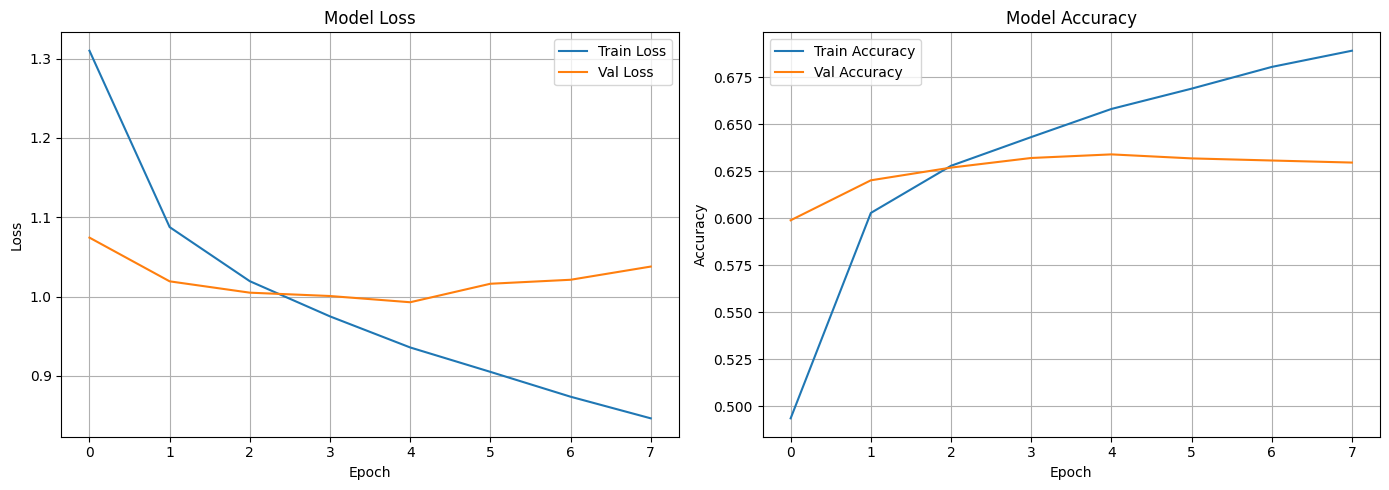

In [49]:
import matplotlib.pyplot as plt

# Crear figura con 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfica de Loss
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Val Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Gráfica de Accuracy
ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [50]:
loss, acc = model_to_train.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

1145/1145 ━━━━━━━━━━━━━━━━━━━━ 161s 140ms/step - accuracy: 0.6341 - loss: 0.9897
Test Accuracy: 0.6345


In [52]:
y_pred_probs = model_to_train.predict(X_test)

y_pred = np.argmax(y_pred_probs, axis=1)

1145/1145 ━━━━━━━━━━━━━━━━━━━━ 157s 137ms/step


## Matriz de confusión

Observamos en la matriz de confusión que el modelo clasifica correctamente, en la mayoría de los casos. Sin embargo, el género pop se confunde mucho entre rock y country, esto puede ser explicado porque probablemente este género presenta similitudes en los patrones, ya que comparten una estructura similar en el vocabulario y letra.

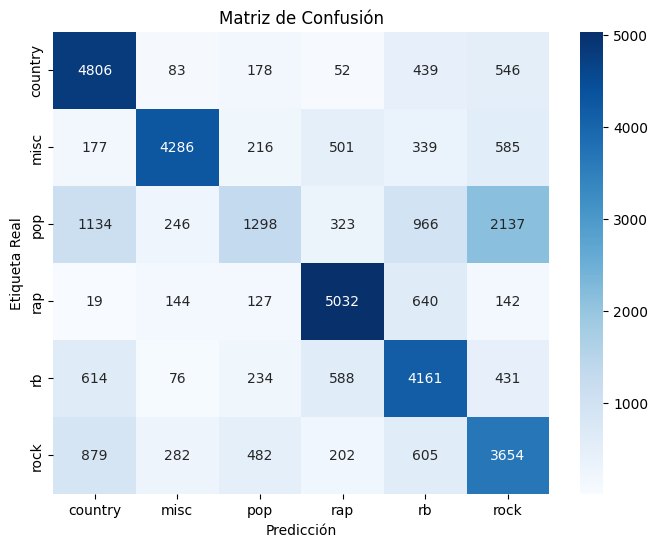

In [56]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()


## Probando el modelo con la letra de una canción

Según Wikipedia, Bang Bang es una canción del genero pop o pop soul, por lo que el modelo debe de clasificarlo de manera correcta con respecto a lo que aprendió.

"Bang Bang" is a song by English singer-songwriter Jessie J, American singer-songwriter Ariana Grande, and American rapper Nicki Minaj. It was released by Lava and Republic Records on 28 July 2014 as the lead single from Jessie J's third studio album, Sweet Talker (2014).

Genre pop
Pop soul

NOTA: No clasifica mejor que el anterior modelo, pero evita un overfitting con el género, por lo que la clasificación mejora debido a que generaliza de mejor forma.

In [121]:
new_lyrics = """
She got a body like an hourglass
But I can give it to you all the time
She got a booty like a Cadillac
But I can send you into overdrive, oh

You've been waiting for that
Step on up, swing your bat
See, anybody could be bad to you
You need a good girl to blow your mind, yeah

Bang, bang into the room (I know you want it)
Bang, bang all over you (I'll let you have it)
Wait a minute, let me take you there (oh)
Wait a minute till you (oh, hey)
Bang, bang, there goes your heart (I know you want it)
Back, back seat of my car (I'll let you have it)
Wait a minute, let me take you there (oh)
Wait a minute till you (oh, hey)

She might'a let you hold her hand in school
But I'ma show you how to graduate (mm-mm)
No, I don't need to hear you talk the talk
Just come and show me what your momma gave ya, baby

I heard you've got a very big (shh)
Mouth, but don't say a thing
See, anybody could be good to you
You need a bad girl to blow your mind

Bang, bang into the room (I know you want it)
Bang, bang all over you (I'll let you have it)
Wait a minute, let me take you there (oh)
Wait a minute till you (oh, hey)
Bang, bang, there goes your heart (there goes your heart now), (I know you want it)
Back, back seat of my car (seat of my car), (I'll let you have it)
Wait a minute, let me take you there (oh), (you know what, girls?)
Wait a minute till you (oh, hey), (let me show you how to do it)

It's Myx Moscato, it's frizz in a bottle, it's Nicki Full Throttle, it's oh, oh
Swimming in The Grotto, we winning in the lotto, we dipping in the powder-blue four-door
Kitten so good, it's dripping on wood, get a ride in the engine that could go
Batman, robbin' it, bang, bang, cockin' it, Queen Nicki dominant, prominent
It's me, Jessie, and Ari, if they test me, they sorry
Ride his uh like a Harley then pull off in his Ferrari
If he hangin', we bangin', phone rangin', he slangin'
It ain't karaoke night, but get the mic, 'cause I'm singin'

Uh, B to the A to the N to the G to the (baby, baby, baby, bae, ba-baby)
Uh, B to the A to the N to the G to the, hey
See, anybody could be good to you
You need a bad girl to blow your mind, your mind (okay)
Hey

Bang, bang into the room (oh), (I know you want it)
Bang, bang all over you (I'll let you have it), (b-bang, bang, bang, bang, baby)
Wait a minute, let me take you there (oh)
Wait a minute till you (oh, yeah), (kyuh, uh-huh)
Bang, bang, there goes your heart (there goes your heart), (I know you want it)
Back, back seat of my car (I'll let you have it)
Wait a minute, let me take you there (let me take you there)
Wait a minute till you (hey)

Bang, bang into the room (I know you want it)
Bang, bang all over you (I'll let you have it)
Yo, I said: Bang, bang, bang, ba-bang, bang (oh)
Bang, bang, bang, bang, ba-bang, bang (oh)
Bang, bang, there goes your heart (I know you want it)
Back, back seat of my car (I'll let you have it)
Wait a minute, let me take you there (oh)
Wait a minute till you (oh, hey)
"""

seq = tokenizer.texts_to_sequences([new_lyrics])
padded = pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')


In [122]:
import numpy as np

pred_probs = model_to_train.predict(padded)
pred_index = np.argmax(pred_probs, axis=1)[0]
pred_label = le.inverse_transform([pred_index])[0]

print(f"Predicción de género: {pred_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Predicción de género: rb
